In [87]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import cv2

import pytorch_lightning as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A

from sklearn.model_selection import train_test_split
from pathlib import Path
from src.utils import custom_to_std_tensor
from src.utils import denormalize
from src.utils import rgb_to_lab_transform
from src.utils import lab_to_rgb_transform
from src.utils import rgb_to_lab
from src.utils import lab_to_rgb
from src.utils import image_to_array
from src.data import CorgiDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
data_folder = Path("data/corgi")
figs_folder = Path("figs")
models_folder = Path("models")
logs_folder = Path("logs")

images_folder = data_folder / "images"

In [12]:
description = pd.read_csv(data_folder / "description.csv")
description["contains"] = description.accessibility_caption.apply(lambda x: x.split("Image may contain:")[1] if x is not np.nan and "Image may contain:" in x else None)
contains_dog = description.contains.apply(lambda x: x is not None and "dog" in x)

In [60]:
dataset = CorgiDataset(description[contains_dog], images_folder, A.Compose([A.Resize(256, 256), rgb_to_lab_transform, custom_to_std_tensor]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, num_workers=0)

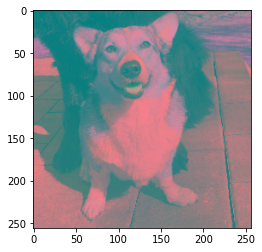

In [61]:
_, img = dataset[1].values()
origin = (np.transpose(denormalize(img).numpy(), (1, 2, 0)))
plt.imshow(origin)

7.65 ms ± 230 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


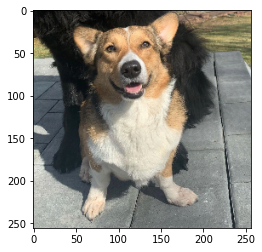

In [97]:
%%timeit
plt.imshow(lab_to_rgb(image_to_array(denormalize(img))))

In [99]:
_, imgs = next(iter(dataloader)).values()

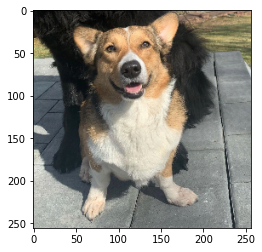

In [104]:
plt.imshow(lab_to_rgb(image_to_array(denormalize(imgs[1]))))

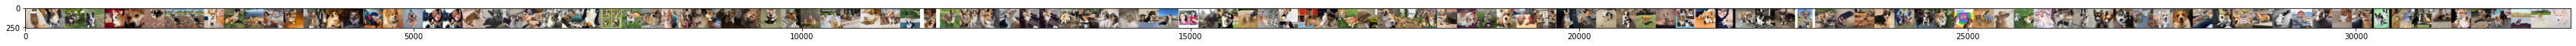

In [106]:
plt.figure(figsize=(60, 5))
plt.imshow(np.hstack([lab_to_rgb(image_to_array(denormalize(img))) for img in imgs]))

## Modeling

In [154]:
class CorgiAutoencoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3, 4, 3, padding=1),
            torch.nn.BatchNorm2d(4),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(4, 4, 3, padding=1, stride=2),
            torch.nn.BatchNorm2d(4),
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(4, 8, 3, padding=1),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 8, 3, padding=1, stride=2),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(8, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(16, 16, 3, padding=1, stride=2),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(16, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(32, 32, 3, padding=1, stride=2),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(32, 64, 3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(64, 64, 3, padding=1, stride=2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(True),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Conv2d(64, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(32, 32, 3, stride=2, output_padding=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(32, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(16, 16, 3, stride=2, output_padding=1, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(16, 8, 3, padding=1),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(8, 8, 3, stride=2, output_padding=1, padding=1),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(8, 4, 3, padding=1),
            torch.nn.BatchNorm2d(4),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(4, 4, 3, stride=2, output_padding=1, padding=1),
            torch.nn.BatchNorm2d(4),
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(4, 3, 3, padding=1),
            torch.nn.BatchNorm2d(3),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(3, 3, 3, stride=2, output_padding=1, padding=1),
            torch.nn.BatchNorm2d(3),
            torch.nn.Tanh(),
        )
        
        self.criterion = torch.nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def training_step(self, train_batch, batch_idx):
        origins = train_batch["origin"]
        outs = self.forward(origins)
        loss = self.criterion(outs, origins)

        logs = {'train_loss': loss}
        return {'loss': loss, "log": logs}

    def validation_step(self, val_batch, batch_idx):
        origins = val_batch["origin"]
        outs = self.forward(origins)
        loss = self.criterion(outs, origins)
        
        
        if batch_idx == 0:
            origins_exmpl = np.hstack([lab_to_rgb(image_to_array(denormalize(img))) for img in origins.cpu()])
            self.logger.experiment.add_image(
                "origins",
                origins_exmpl,
                global_step=self.current_epoch,
                dataformats="HWC",
            )
            
            outs_exmpl = np.hstack([lab_to_rgb(image_to_array(denormalize(img))) for img in outs.cpu()])
            self.logger.experiment.add_image(
                "outs",
                outs_exmpl,
                global_step=self.current_epoch,
                dataformats="HWC",
            )
        
        return {'val_loss': loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        
#         current_lr = [pg for pg in optimizer.param_groups][0]["lr"]
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}
    
    def prepare_data(self):
        self.train_df, self.val_df = train_test_split(
            description[contains_dog],
            train_size=0.9,
            random_state=42
        )
        
        self.transforms = A.Compose([
            A.Resize(256, 256),
            rgb_to_lab_transform,
            custom_to_std_tensor,
        ])
                
    def train_dataloader(self):
        dataset = CorgiDataset(self.train_df, images_folder, self.transforms)
        dataloader = torch.utils.data.DataLoader(
            dataset, 
            batch_size=128,
            shuffle=True,
            num_workers=10
        )
        return dataloader

    def val_dataloader(self):
        dataset = CorgiDataset(self.val_df, images_folder, self.transforms)
        dataloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=128,
            shuffle=False,
            num_workers=10
        )
        return dataloader

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)
        return [optimizer], [scheduler]



In [155]:
autoencoder = CorgiAutoencoder()
print(autoencoder(torch.rand(1, 3, 256, 256)).shape)
print(autoencoder.encoder(torch.rand(1, 3, 256, 256)).shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 64, 8, 8])


In [156]:
model = CorgiAutoencoder()
model_name = "corgi-autoencoder-v1"

logger = pl.loggers.TensorBoardLogger(logs_folder, name=model_name)
checkpoint_callback = pl.callbacks.ModelCheckpoint(models_folder / model_name)
trainer = pl.Trainer(checkpoint_callback=checkpoint_callback, logger=logger, gpus=1)

trainer.fit(model)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name       | Type            | Params
-------------------------------------------
0  | encoder    | Sequential      | 74 K  
1  | encoder.0  | Conv2d          | 112   
2  | encoder.1  | BatchNorm2d     | 8     
3  | encoder.2  | ReLU            | 0     
4  | encoder.3  | Conv2d          | 148   
5  | encoder.4  | BatchNorm2d     | 8     
6  | encoder.5  | ReLU            | 0     
7  | encoder.6  | Conv2d          | 296   
8  | encoder.7  | BatchNorm2d     | 16    
9  | encoder.8  | ReLU            | 0     
10 | encoder.9  | Conv2d          | 584   
11 | encoder.10 | BatchNorm2d     | 16    
12 | encoder.11 | ReLU            | 0     
13 | encoder.12 | Conv2d          | 1 K   
14 | encoder.13 | BatchNorm2d     | 32    
15 | encoder.14 | ReLU            | 0     
16 | encoder.15 | Conv2d          | 2 K   
17 | encoder.16 | BatchNorm2d     | 32    
18 | encoder.17 | ReLU            | 0     
19

/home/devel/miniconda3/envs/diploma/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)


INFO:lightning:Detected KeyboardInterrupt, attempting graceful shutdown...


1

In [223]:
trainer.optimizers

[Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 3.125e-05
     weight_decay: 1e-05
 )]

In [228]:
3.125e-05 * 2 * 2 *2 * 2 * 2

0.001

In [221]:
transforms = A.Compose([
    A.Resize(256, 256),
    rgb_to_lab_transform,
    custom_to_std_tensor,
])

with torch.no_grad():
    model.eval()
    _, img = CorgiDataset(description, images_folder, transforms)[4564].values()
    out = model(img.cuda().unsqueeze(0))
    out = out.cpu()[0]

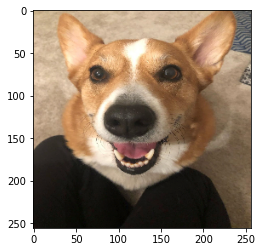

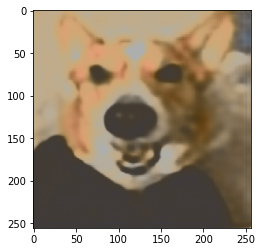

In [222]:
plt.imshow(lab_to_rgb(image_to_array(denormalize(img))))
plt.show()
plt.imshow(lab_to_rgb(image_to_array(denormalize(out))))
plt.show()

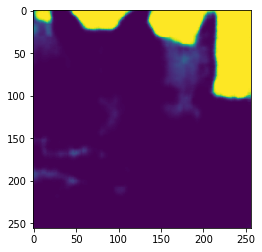

In [25]:
plt.imshow(torchvision.transforms.functional.to_pil_image(denormalize(out)[2]))


In [35]:
denormalize(out)[:, 8, 45] - denormalize(out)[:, 56, 45]

tensor([0.0019, 0.0012, 0.0011])

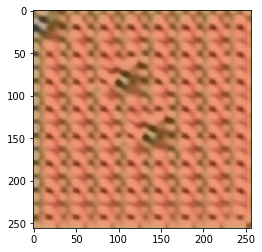

In [251]:
with torch.no_grad():
    model.eval()
#     noise = torch.empty(64, 8, 8).normal_(mean=0,std=0.5)
    noise = torch.zeros(64, 8, 8)
    noise[:, 0, 0] = 0.5
    noise[:, 4, 4] = 0.5
    noise[:, 2, 3] = 0.5
    out = model.decoder(noise.cuda().unsqueeze(0))
    out = out.cpu()[0]
    
plt.imshow(lab_to_rgb(image_to_array(denormalize(out))))
plt.show()

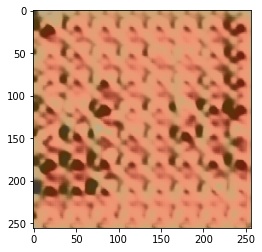

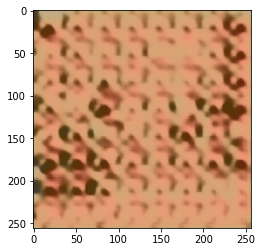

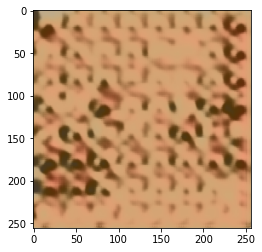

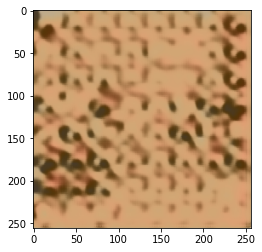

In [342]:
img = cv2.imread("data/other/me.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transforms = A.Compose([
    A.Resize(256, 256),
    rgb_to_lab_transform,
    custom_to_std_tensor,
])
transformed = transforms(image=img)
img = transformed["image"]

with torch.no_grad():
    model.eval()
    code = model.encoder(img.cuda().unsqueeze(0))
#     code[0, 54, :, :] = 0
#     code[0, 46, :, :] = 0
    code[0, 0:31, :, :] = 0
    code[0, 44:, :, :] = 0
    out = model.decoder(code)
    out = out.cpu()[0]
    
    out2 = model(out.cuda().unsqueeze(0))
    out2 = out2.cpu()[0]
    
    out3 = model(out2.cuda().unsqueeze(0))
    out3 = out3.cpu()[0]

    out4 = model(out3.cuda().unsqueeze(0))
    out4 = out4.cpu()[0]
    
    
plt.imshow(lab_to_rgb(image_to_array(denormalize(out))))
plt.show()

plt.imshow(lab_to_rgb(image_to_array(denormalize(out2))))
plt.show()

plt.imshow(lab_to_rgb(image_to_array(denormalize(out3))))
plt.show()

plt.imshow(lab_to_rgb(image_to_array(denormalize(out4))))
plt.show()

(array([2.27e+03, 8.18e+02, 5.82e+02, 2.25e+02, 1.27e+02, 5.40e+01,
        9.00e+00, 6.00e+00, 4.00e+00, 1.00e+00]),
 array([0.        , 0.20860775, 0.4172155 , 0.62582326, 0.834431  ,
        1.0430387 , 1.2516465 , 1.4602542 , 1.668862  , 1.8774697 ,
        2.0860775 ], dtype=float32),
 <a list of 10 Patch objects>)

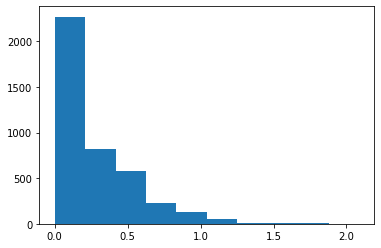

In [268]:
plt.hist(code.flatten().cpu())

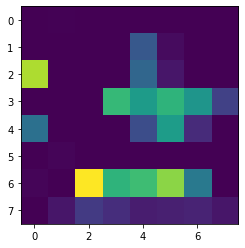

In [327]:
plt.imshow(code[0, 46, :, :].cpu().numpy())